In [1]:
import pandas as pd
import numpy as np
import inspect
import time
from itertools import combinations
from sklearn import model_selection,svm,metrics,linear_model
from sklearn.preprocessing import MinMaxScaler


from collections import defaultdict

In [2]:
def get_csv(ptnum,tube,markers):
    fcs = 'C:\\python27\\FCSlog10\\' + str(8*(ptnum-1)+tube) + '.csv'
    return np.genfromtxt(fcs, delimiter=',',usecols=markers)[1:,:].astype(int)

def histo(data):
    """
    Input array of cells x markers. Marker levels must already be converted to bin numbers, 
    i.e. signal of 815 of max 1000 is bin 8.
    For each cell, the bin numbers are combined into a combination specific to the n-dimensional
    hypercube in the n-dimensional data space. 
    i.e. Cell #415 has signal 457 for SSC and 180 for CD15. If we are only considering those 2
    markers, the 'index' for the 2-d histogram bin is '4,1'. 
    Defaultdict functions as a counter, incrementing for the appropriate bin index for every 
    cell in the array.    
    """
    
    d = defaultdict(int) 
    for cell in data:
        d[tuple(cell)] += 1
    return d

def scale_data(data):
    """
    MinMaxScaler normalizes data to 0-1. -1 to 1 may also be used, does not affect SVM results.
    """
    
    scale = MinMaxScaler()
    #scale = MaxAbsScaler()
    data = scale.fit_transform(data)
    #data = data[:,data.sum(axis=0)!=0] # drop 100% empty columns
    return data

def get_combo(tube,markers):
    """
    Input a given tube and set of markers to consider. 
    Calls histo() for every patient and adds the result as a new row in a df. 
    Returns 359 row df. Columns represent bin indexes. Data is counts of cells falling in those bins.
    """
    
    #start = time.time()
    combo_hist = pd.DataFrame(histo(get_csv(1,tube,markers)),index=[0])
    
    for ptnum in range(2,360):
        combo_hist.ix[ptnum-1,:] = histo(get_csv(ptnum,tube,markers))

    #print('combo complete - ' + str((time.time()-start)/60) + 'min')
    return combo_hist

def all_combos(tube,n_d):
    """
    Input tube and number of markers to consider.
    For every combination of markers (however many markers at a time we are considering),
    call tube_data() to get histo data for all cells for every patient for that combo.
    Iterate for every combo of markers and concat.
    Output is 359 patients x nCr dfs concat'ed horizontally, where m_columns in those 
    dfs depends on how many bins actually had cells (no cells in the bin for all 
    patients = not added to df).
    """    
    
    start = time.time()
    firstcombo = True
    tube_data = pd.DataFrame()
    for markers in combinations(range(1,8),n_d):
        if firstcombo == True:
            tube_data = get_combo(tube,markers)
            firstcombo = False
        else:
            tube_data = pd.concat([tube_data, get_combo(tube,markers)],axis = 1)
    tube_data = scale_data(tube_data.fillna(0))
    
    print('tube complete - ' + str((time.time()-start)/60) + 'min')
    return tube_data

def gridsearch(X,Y,algorithm,params,cv,scoring):
    """
    Grid search iterator for finding C.
    Input data, labels, algo (SVM), range of C to test, CV method, scoring method)
    Output result grid
    """                                
                                
    #start = time.time()
    grid = model_selection.GridSearchCV(algorithm, param_grid=params, cv=cv, scoring = scoring)
    grid.fit(X,Y)
    #print 'gridsearch: ' + str((time.time()-start)/60) + 'min'
    return pd.DataFrame(grid.cv_results_)

def split_and_fit(data):
    """
    Create preds from tube data generated from all_tubes().
    Input data from all_tubes(). 
    Create test folds of 72 (5 folds total). 
    For training 80% of data, run gridsearch and select C that produces highest test score.
    Use that C to predict on test fold.
    Repeat for remaining folds.  Add predictions to end of list of previous fold(s).
    Return 359 predictions.    
    """
    
    start = time.time()
    Y = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    
    #Y = Y.drop(339,axis = 0).reset_index(drop = True)
    #data = np.delete(data,339,0)
    
    predictions = list()
    
    step = 72
    ptlist = range(0,Y.shape[0])[::step]
    
    for pt in ptlist:

        if pt == 180:
            print('pt 180 complete')
        
        try:
            XTRAIN, XTEST = np.delete(data, range(pt,pt+step), 0), data[pt:pt+step]
            YTRAIN = Y.drop(range(pt,pt+step),axis = 0).as_matrix().reshape(Y.shape[0]-step,)
        except ValueError: 
            print pt
            XTRAIN, XTEST = np.delete(data, range(pt,Y.shape[0]), 0), data[pt:Y.shape[0]]
            YTRAIN = Y.drop(range(pt,Y.shape[0]),axis = 0).as_matrix().reshape(pt,)
        
        hiC = 6
        lowC = -6
        
        f1_scorer = metrics.make_scorer(metrics.f1_score, labels=['aml','normal'], pos_label='aml')
        algorithm, params, scoring = svm.LinearSVC(), {'C': np.logspace(lowC, hiC, hiC-lowC+1, endpoint=True)}, f1_scorer
        cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
        results = gridsearch(XTRAIN, YTRAIN, algorithm, params, cv, scoring)
        
        #gamma = results.ix[results['mean_test_score'].idxmax(),5]
        C = results.ix[results['mean_test_score'].idxmax(),4]
        #if (C==10**hiC)|(C==10**lowC):
        print C
                
        linSVC = svm.LinearSVC(C = C)
        linSVC.fit(XTRAIN,YTRAIN)
        predictions.extend(linSVC.predict(XTEST))
        #predictions.extend(list(logREG.predict_proba(XTEST)[:,0]))
    print 'split_and_fit: ' + str((time.time()-start)/60) + 'min'
    return predictions

def pred_map(n_d):
    """
    Create 359 x 8 map. First column is true label for all patients (gold standard). 
    Remaining columns are preds corresponding to 1 tube per column.
    Also return a separate master list of preds based on this map where if any one tube was 
    called positive, the master pred was positive.
    """
                                
    master = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    
    for tube in range(1,8):
        data = all_combos(tube, n_d)
        master[tube] = split_and_fit(data)
        print('Tube ' + str(tube) + ' complete')
    
    predictions = []
    for i in range(0,359):
        if 'aml' in master[range(1,8)].loc[i].values.tolist():
            predictions.extend(['aml'])
        else: 
            predictions.extend(['normal'])
    return master,predictions

def f1(YPRED):
    """
    f1 function = 2 * harmonic mean of recall and precision.
    Input list of preds.
    Compare with gold standard labels.
    Output f1, recall, precision, TP, FP, FN
    """
                                
    Y = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    YTEST = Y['Condition'].tolist()
    TP, FN, FP = 0., 0., 0.
    for i in range(0,len(YTEST)):
        if (YTEST[i] == 'aml') and (YPRED[i]=='aml'):
            TP += 1
        if (YTEST[i] == 'aml') and (YPRED[i]=='normal'):    
            FN += 1
        if (YTEST[i] == 'normal') and (YPRED[i]=='aml'):
            FP += 1
    try: 
        recall = TP / (TP + FN)
        precision = TP / (TP + FP)
        f1 = 2 * (recall * precision) / (recall + precision)
    except ZeroDivisionError:
        return 0
        
    return f1, recall, precision, TP, FP, FN

In [8]:
Y, predictions = pred_map(3)
Y.to_csv("C:\\python27\\3dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
pd.options.display.max_rows = 360
f1(predictions)

combo complete - 1.04468333324min
combo complete - 1.064016668min
combo complete - 1.15016666651min
combo complete - 1.12088333368min
combo complete - 1.1158833305min
combo complete - 1.10931666692min
combo complete - 1.10715000232min
combo complete - 1.1162833333min
combo complete - 1.11721666654min
combo complete - 1.11735000213min
combo complete - 1.10546666781min
combo complete - 1.1165833354min
combo complete - 1.08718333244min
combo complete - 1.08571666479min
combo complete - 1.06233333349min
combo complete - 1.08008333445min
combo complete - 1.04293333292min
combo complete - 1.04931666454min
combo complete - 1.07291666667min
combo complete - 1.04308333397min
combo complete - 1.05618333419min
combo complete - 1.04115000168min
combo complete - 1.02901666562min
combo complete - 1.02471666733min
combo complete - 1.03848333359min
combo complete - 1.03248333136min
combo complete - 1.02808333635min
combo complete - 1.02480000257min
combo complete - 1.03744999965min
combo complete - 1.

(0.898876404494382, 0.9302325581395349, 0.8695652173913043, 40.0, 6.0, 3.0)

In [4]:
Y, predictions = pred_map(4)
Y.to_csv("C:\\python27\\4dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
pd.options.display.max_rows = 360
f1(predictions)

tube complete - 48.3627999981min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.595850002766min
Tube 1 complete
tube complete - 44.725516665min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.992533334096min
Tube 2 complete
tube complete - 46.2189833323min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.00821666718min
Tube 3 complete
tube complete - 46.5275333325min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.12939999898min
Tube 4 complete
tube complete - 46.1878833334min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.885716668765min
Tube 5 complete
tube complete - 45.3568833311min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.0409166654min
Tube 6 complete
tube complete - 44.6849499981min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.860750003656min
Tube 7 complete


(0.9195402298850575, 0.9302325581395349, 0.9090909090909091, 40.0, 4.0, 3.0)

In [5]:
Y, predictions = pred_map(5)
Y.to_csv("C:\\python27\\5dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
pd.options.display.max_rows = 360
f1(predictions)

tube complete - 30.4176333348min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.583716666698min
Tube 1 complete
tube complete - 29.8738666693min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.989383331935min
Tube 2 complete
tube complete - 30.1121333321min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.14814999898min
Tube 3 complete
tube complete - 30.5892500003min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.24671666622min
Tube 4 complete
tube complete - 29.9484500011min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.985649998983min
Tube 5 complete
tube complete - 30.4602666696min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 1.25043332974min
Tube 6 complete
tube complete - 29.7151166677min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.959666665395min
Tube 7 complete


(0.963855421686747, 0.9302325581395349, 1.0, 40.0, 0.0, 3.0)

In [6]:
Y, predictions = pred_map(6)
Y.to_csv("C:\\python27\\6dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
pd.options.display.max_rows = 360
f1(predictions)

tube complete - 11.2517833352min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.324616666635min
Tube 1 complete
tube complete - 11.7448166649min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.519366665681min
Tube 2 complete
tube complete - 11.8004999995min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.59361666441min
Tube 3 complete
tube complete - 12.342383333min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.613933336735min
Tube 4 complete
tube complete - 11.8678333322min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.501916666826min
Tube 5 complete
tube complete - 12.1205833356min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.643833335241min
Tube 6 complete
tube complete - 11.6261333307min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.504700001081min
Tube 7 complete


(0.9761904761904763, 0.9534883720930233, 1.0, 41.0, 0.0, 2.0)

In [7]:
Y, predictions = pred_map(7)
Y.to_csv("C:\\python27\\7dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
pd.options.display.max_rows = 360
f1(predictions)

tube complete - 1.87073333263min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.0844499985377min
Tube 1 complete
tube complete - 1.99468333324min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.115566666921min
Tube 2 complete
tube complete - 2.01041666667min
10.0
100.0
100.0
10.0
288
10.0
split_and_fit: 0.124550000827min
Tube 3 complete
tube complete - 2.12708333333min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.123233334223min
Tube 4 complete
tube complete - 2.02884999911min
10.0
10.0
10.0
100.0
288
10.0
split_and_fit: 0.108416668574min
Tube 5 complete
tube complete - 2.08779999812min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.131016667684min
Tube 6 complete
tube complete - 1.96243333419min
10.0
10.0
10.0
10.0
288
10.0
split_and_fit: 0.11318333149min
Tube 7 complete


(0.8602150537634408, 0.9302325581395349, 0.8, 40.0, 10.0, 3.0)

In [8]:
Y = pd.read_csv("C:\\python27\\6dhist5fold.csv")
Y.insert(1,"Ypred",predictions)
Y

,Unnamed: 0,Ypred,Condition,1,2,3,4,5,6,7
0,0,normal,normal,normal,normal,normal,normal,normal,normal,normal
1,1,normal,normal,normal,normal,normal,normal,normal,normal,normal
2,2,normal,normal,normal,normal,normal,normal,normal,normal,normal
3,3,normal,normal,normal,normal,normal,normal,normal,normal,normal
4,4,aml,aml,normal,aml,normal,aml,aml,aml,normal
5,5,normal,normal,normal,normal,normal,normal,normal,normal,normal
6,6,normal,aml,normal,normal,normal,normal,normal,normal,normal
7,7,normal,normal,normal,normal,normal,normal,normal,normal,normal
8,8,aml,aml,aml,aml,aml,aml,aml,aml,aml
9,9,normal,normal,normal,normal,normal,normal,normal,normal,normal


In [4]:
data = all_combos(2,2)
data.shape

tube complete - 18.0230833332min


(359L, 1295L)

In [5]:
data = all_combos(2,3)
data.shape

tube complete - 34.8737333337min


(359L, 9188L)

In [3]:
data = all_combos(2,4)
data.shape

tube complete - 40.8201499979min


(359L, 25519L)

In [9]:
data = all_combos(2,2)
data.shape

tube complete - 18.3541666667min


(359L, 1295L)

In [10]:
Y = pd.read_csv('C:\\python27\\CAPSTONE\\Y.csv')
    
    #Y = Y.drop(339,axis = 0).reset_index(drop = True)
    #data = np.delete(data,339,0)
XTRAIN = data
YTRAIN = Y
hiC = 6
lowC = -6
        
f1_scorer = metrics.make_scorer(metrics.f1_score, labels=['aml','normal'], pos_label='aml')
algorithm, params, scoring = svm.LinearSVC(), {'C': np.logspace(lowC, hiC, hiC-lowC+1, endpoint=True)}, f1_scorer
cv = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
results = gridsearch(XTRAIN, YTRAIN, algorithm, params, cv, scoring)

In [48]:
r = results[range(2,5)]
r

,mean_test_score,mean_train_score,param_C
0,0.000000,0.000000,1e-06
1,0.000000,0.000000,1e-05
2,0.000000,0.000000,0.0001
3,0.269091,0.320124,0.001
4,0.838870,0.945572,0.01
5,0.870866,0.988060,0.1
6,0.856564,1.000000,1
7,0.856564,1.000000,10
8,0.858422,1.000000,100
9,0.858422,1.000000,1000


In [29]:
r.ix[:,2].tolist()

[9.9999999999999995e-07,
 1.0000000000000001e-05,
 0.0001,
 0.001,
 0.01,
 0.10000000000000001,
 1.0,
 10.0,
 100.0,
 1000.0,
 10000.0,
 100000.0,
 1000000.0]

([<matplotlib.axis.XTick at 0xc649ef0>,
 <a list of 13 Text xticklabel objects>)

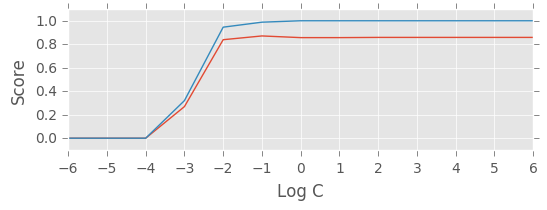

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.figure(1)
plt.subplot(211)
plt.plot(np.log10(r.ix[:,2].tolist()),r[[0]])
plt.plot(np.log10(r.ix[:,2].tolist()),r[[1]])
plt.ylim(-.1,1.1)
plt.ylabel('Score')
plt.xlabel('Log C')
plt.xticks(range(-6,7))
#f.subplots_adjust(bottom=0)
#f.subplots_adjust(top=1)

In [40]:
r.ix[3:7,2]

3    0.001
4     0.01
5      0.1
6        1
7       10
Name: param_C, dtype: object

([<matplotlib.axis.XTick at 0x1aa6f7b8>,
 <a list of 5 Text xticklabel objects>)

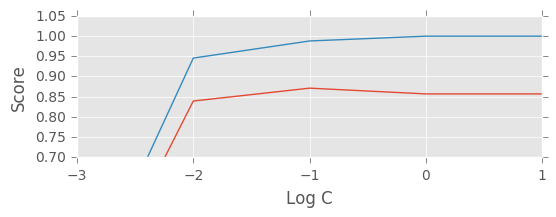

In [47]:
plt.style.use('ggplot')
plt.figure(1)
plt.subplot(211)
plt.plot(np.log10(r.ix[3:7,2].tolist()),r.ix[3:7,0])
plt.plot(np.log10(r.ix[3:7,2].tolist()),r.ix[3:7,1])
plt.ylim(.7,1.05)
plt.ylabel('Score')
plt.xlabel('Log C')
plt.xticks(range(-3,2))
#f.subplots_adjust(bottom=0)
#f.subplots_adjust(top=1)

In [8]:
results[range(2,7)]

,mean_test_score,mean_train_score,param_C,params,rank_test_score
0,0.000000,0.00000,1e-06,{u'C': 1e-06},12
1,0.000000,0.00000,1e-05,{u'C': 1e-05},12
2,0.259091,0.37162,0.0001,{u'C': 0.0001},11
3,0.872353,0.98806,0.001,{u'C': 0.001},10
4,0.894590,1.00000,0.01,{u'C': 0.01},1
5,0.889361,1.00000,0.1,{u'C': 0.1},2
6,0.889361,1.00000,1,{u'C': 1.0},2
7,0.889361,1.00000,10,{u'C': 10.0},2
8,0.889361,1.00000,100,{u'C': 100.0},2
9,0.889361,1.00000,1000,{u'C': 1000.0},2


In [7]:
data = all_combos(2,5)
data.shape

tube complete - 43.9361833334min


(359L, 32384L)

In [8]:
data = all_combos(2,6)
data.shape

tube complete - 16.1268166661min


(359L, 19158L)

In [9]:
data = all_combos(2,7)
data.shape

tube complete - 2.17625000079min


(359L, 4294L)